In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pydeseq2.preprocessing import deseq2_norm

In [26]:
def create_groups(metadata, col, principalComponents):
    condition_list = metadata[col].to_list()
    
    # Group data points by conditions for PCA plot labeling
    groups = {}
    for i, label in enumerate(condition_list):
        if label not in groups:
            groups[label] = []
        groups[label].append(principalComponents[i])
    
    return groups

def run_PCA(df, standardize, n_components, metadata, plot_title, normalization_method, save_dir):
    """
    For quick use of PCA to asses normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before pca, can be either True or False
    :param n_components: number of components for PCA, data type:int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param plot_title: title for saving PCA results, data type:str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Drop NaN for PCA
    df = df.dropna()
    print(f"{len(df.index)} features are kept are NaN Removal")
    
    # Standardize the data for PCA
    if standardize == True:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df
    else:
        print('standardise not defined, True or False is needed')
    
    # Run pca
    print(f'Running PCA with n_componenets={n_components}')
    pca = PCA(n_components=n_components)  
    principalComponents = pca.fit_transform(df_scaled)
    
    # Plot individual 
    plt.figure(figsize=(8, 6))
    for i in range(principalComponents.shape[0]):
        plt.scatter(principalComponents[i, 0], principalComponents[i, 1], alpha=0.7)  
        plt.annotate(df.columns[i],  
                     (principalComponents[i, 0], principalComponents[i, 1]), 
                     textcoords="offset points", 
                     xytext=(5,5), 
                     ha='center') 

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.savefig(save_dir + normalization_method + '_colored_by_sample_id.pdf')
    plt.show()
    
    # Plot colored by group
    groups = create_groups(metadata = metadata, col = 'condition', principalComponents=principalComponents)
    
    import matplotlib.patches as patches
    from scipy.stats import chi2

    plt.figure(figsize=(8, 6))

    # Define a color for each group
    group_colors = {'Control': 'blue', 'Iso_Young': 'yellow', 'Het_YO': 'green', 'Het_OY': 'red', 'Iso_Old': 'orchid'}

    for label, group in groups.items():
        group = np.array(group)
        group = group[:,:2]
        color = group_colors[label]
    
        # Scatter plot for the group
        plt.scatter(group[:, 0], group[:, 1], alpha=0.7, label=label)

        # Calculate the mean and covariance
        group_mean = np.mean(group, axis=0)
        group_cov = np.cov(group, rowvar=False)

        # Calculate the width, height, and angle for the ellipse
        lambda_, v = np.linalg.eig(group_cov)
        ## Determine scale for 95% confidence
        k = np.sqrt(chi2.ppf(0.95, 2))
        lambda_2sqrt = 2 * k * np.sqrt(lambda_)
        ell_width, ell_height = lambda_2sqrt[0], lambda_2sqrt[1]
        angle = np.rad2deg(np.arctan2(*v[:,0][::-1]))

        # Create an Ellipse patch
        ell = patches.Ellipse((group_mean[0], group_mean[1]), ell_width, ell_height, angle=angle, edgecolor=color, facecolor=color, alpha=0.3)
    
        # Add the Ellipse to the plot
        plt.gca().add_patch(ell)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.legend()
    plt.savefig(save_dir + normalization_method + '_colored_by_condition.pdf')
    plt.show()
    
    
    return

In [27]:
counts_path = './Count/'

df = pd.read_excel(counts_path + 'gene_count.xlsx')

In [28]:
df

,gene_id,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
0,ENSG00000087086,970895,1034423,892501,1388047,775924,1378575,1729652,764418,755015,653410,710859,1068922,606887,694409,1285837,643450
1,ENSG00000099194,758995,707989,456631,993534,744140,453454,1340891,932497,524513,321366,223514,387925,283468,179527,109249,84742
2,ENSG00000170323,397757,407701,277218,542059,375946,627593,536999,329452,370540,505930,372928,596140,378280,335368,297210,221021
3,ENSG00000211445,257058,190297,237187,238826,194299,287884,269345,185926,162489,96671,161762,219418,115855,162083,335091,222987
4,ENSG00000210082,125932,121490,69583,268364,179351,153891,273472,171583,153661,160245,155205,239391,136164,113602,120411,66433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58730,ENSG00000276351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58731,ENSG00000275661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58732,ENSG00000277856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58733,ENSG00000275063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# re-format the dataframes to put gene_name as rownames (indexes)

def NameRows_Gene(df):
    df_data = df.iloc[: , 1:]
    df_label = df['gene_id']
    df_data.index = df_label
    return df_data

df = NameRows_Gene(df)
df

,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
gene_id,,,,,,,,,,,,,,,,
ENSG00000087086,970895,1034423,892501,1388047,775924,1378575,1729652,764418,755015,653410,710859,1068922,606887,694409,1285837,643450
ENSG00000099194,758995,707989,456631,993534,744140,453454,1340891,932497,524513,321366,223514,387925,283468,179527,109249,84742
ENSG00000170323,397757,407701,277218,542059,375946,627593,536999,329452,370540,505930,372928,596140,378280,335368,297210,221021
ENSG00000211445,257058,190297,237187,238826,194299,287884,269345,185926,162489,96671,161762,219418,115855,162083,335091,222987
ENSG00000210082,125932,121490,69583,268364,179351,153891,273472,171583,153661,160245,155205,239391,136164,113602,120411,66433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000275661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000277856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df.columns

Index(['Ctrl1', 'Ctrl2', 'Ctrl3', 'YY1', 'YY2', 'YY3', 'YO1', 'YO2', 'YO3',
       'OY1', 'OY2', 'OY3', 'OO1', 'OO2', 'OO3', 'OY3_1'],
      dtype='object')

In [31]:
# Build a dataframe with sample-condition annotation (serving as metadata for DESeq2)
conditions_annotate = {'Ctrl1':'Control', 'Ctrl2':'Control', 'Ctrl3':'Control',
                       'YY1':'Iso_Young', 'YY2':'Iso_Young', 'YY3':'Iso_Young', 
                       'YO1':'Het_YO', 'YO2':'Het_YO', 'YO3':'Het_YO',
                       'OY1':'Het_OY', 'OY2':'Het_OY', 'OY3':'Het_OY', 
                       'OO1':'Iso_Old', 'OO2':'Iso_Old', 'OO3':'Iso_Old', 
                       'OY3_1':'Het_OY'
                       }

condition_metadata = pd.Series(conditions_annotate)
metadata = pd.DataFrame(condition_metadata)
metadata.columns = ['condition']

# Add backup as another design factor in addition to condition for future DE analysis
backup_list = ['NaN']*15 + ['BackUp']
metadata['backup'] = backup_list

metadata

,condition,backup
Ctrl1,Control,NaN
Ctrl2,Control,NaN
Ctrl3,Control,NaN
YY1,Iso_Young,NaN
YY2,Iso_Young,NaN
YY3,Iso_Young,NaN
YO1,Het_YO,NaN
YO2,Het_YO,NaN
YO3,Het_YO,NaN
OY1,Het_OY,NaN


58735 features are kept are NaN Removal
Running PCA with n_componenets=4


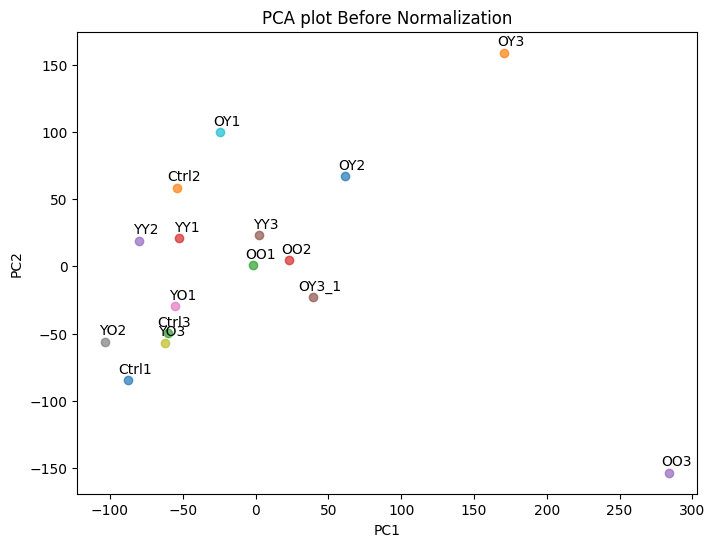

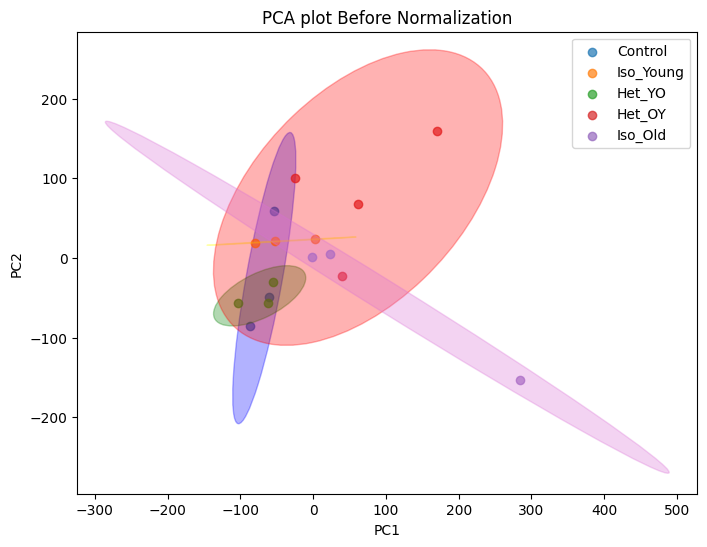

In [32]:
# Run run_PCA to assess sample variation before any normalization
PCA_save_dir = '/Volumes/Elements/20240213_Serum_Change_RNAseq_novogene/Results_Yuchen/0_PCA/'

run_PCA(df=df, standardize=True, n_components=4, 
        metadata = metadata,
        plot_title='PCA plot Before Normalization',
        normalization_method='Raw',
        save_dir = PCA_save_dir)

In [33]:
# Perform median of ratios normalization (default method of DESeq2)
norm = deseq2_norm(df.T)
norm_df = norm[0].T

# Normalized Counts save_dir
Normalized_counts_save_dir = '/Volumes/Elements/20240213_Serum_Change_RNAseq_novogene/Results_Yuchen/1_Normalized_Counts/'
norm_df.to_excel(Normalized_counts_save_dir + '1_Median_of_Ratios_normalized_counts_All_sample.xlsx')

In [35]:
# Save median of ratios size factors for future use
np.savetxt(Normalized_counts_save_dir+'SizeFactor.csv', norm[1], delimiter=',')

58735 features are kept are NaN Removal
Running PCA with n_componenets=10


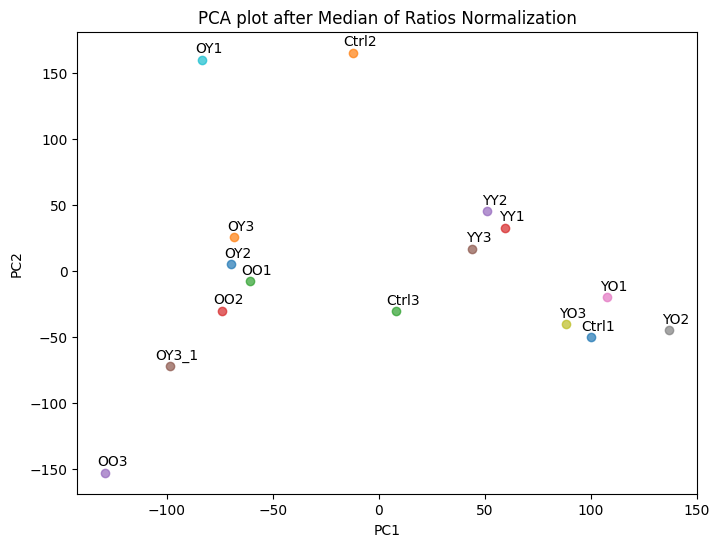

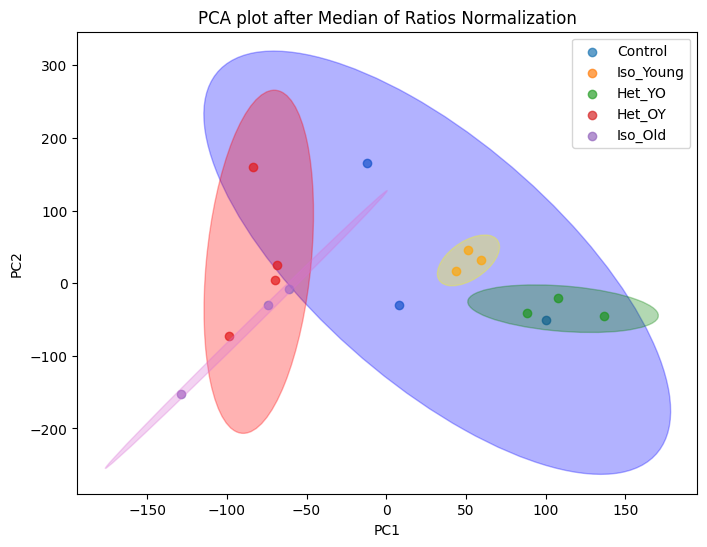

In [16]:
run_PCA(df=norm_df, standardize=True, n_components=10, 
        metadata = metadata,
        plot_title='PCA plot after Median of Ratios Normalization',
        normalization_method='Median_of_Ratios',
        save_dir = PCA_save_dir)

In [3]:
# PCA with FPKM
counts_path = './Count/'

fpkm_df = pd.read_excel(counts_path + 'gene_fpkm.xlsx')

In [4]:
fpkm_df

,gene_id,OY1,OY2,OY3,OY3_1,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OO1,OO2,OO3
0,ENSG00000087086,42799.947249,36295.007657,43394.540001,38160.366159,77048.200226,72060.829920,65072.225389,88552.598823,55837.431467,76423.458764,115293.008902,62052.206246,53732.447259,38035.596043,41166.756973,54686.090098
1,ENSG00000170323,20842.844431,11975.606457,15221.113848,8244.045217,19852.589516,17862.899940,12712.105003,21749.676246,17015.347118,21881.821913,22512.660118,16820.061071,16585.372727,14910.934747,12504.376258,7949.933036
2,ENSG00000099194,3446.871479,1868.683983,2578.722137,822.932367,9862.723436,8075.981354,5451.550581,10378.810429,8768.566570,4116.207258,14635.427821,12394.855608,6112.304816,2909.069771,1742.724732,760.809859
3,ENSG00000210082,5911.399971,4462.903897,5473.250092,2218.860473,5628.267564,4766.394931,2857.185896,9642.059268,7268.728550,4804.607480,10266.100409,7844.205812,6158.757399,4806.103214,3792.850220,2884.068154
4,ENSG00000211445,1757.717158,2292.636793,2472.615854,3670.900361,5662.610399,3679.835095,4800.352768,4229.354301,3881.254640,4430.055253,4983.660875,4189.495925,3209.965251,2015.544992,2667.252342,3955.934050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58730,ENSG00000276351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58731,ENSG00000275661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58732,ENSG00000277856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58733,ENSG00000275063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
def NameRows_Gene(df):
    df_data = df.iloc[: , 1:]
    df_label = df['gene_id']
    df_data.index = df_label
    return df_data

fpkm_df = NameRows_Gene(fpkm_df)
fpkm_df

,OY1,OY2,OY3,OY3_1,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OO1,OO2,OO3
gene_id,,,,,,,,,,,,,,,,
ENSG00000087086,42799.947249,36295.007657,43394.540001,38160.366159,77048.200226,72060.829920,65072.225389,88552.598823,55837.431467,76423.458764,115293.008902,62052.206246,53732.447259,38035.596043,41166.756973,54686.090098
ENSG00000170323,20842.844431,11975.606457,15221.113848,8244.045217,19852.589516,17862.899940,12712.105003,21749.676246,17015.347118,21881.821913,22512.660118,16820.061071,16585.372727,14910.934747,12504.376258,7949.933036
ENSG00000099194,3446.871479,1868.683983,2578.722137,822.932367,9862.723436,8075.981354,5451.550581,10378.810429,8768.566570,4116.207258,14635.427821,12394.855608,6112.304816,2909.069771,1742.724732,760.809859
ENSG00000210082,5911.399971,4462.903897,5473.250092,2218.860473,5628.267564,4766.394931,2857.185896,9642.059268,7268.728550,4804.607480,10266.100409,7844.205812,6158.757399,4806.103214,3792.850220,2884.068154
ENSG00000211445,1757.717158,2292.636793,2472.615854,3670.900361,5662.610399,3679.835095,4800.352768,4229.354301,3881.254640,4430.055253,4983.660875,4189.495925,3209.965251,2015.544992,2667.252342,3955.934050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000275661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000277856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
fpkm_df.columns

Index(['OY1', 'OY2', 'OY3', 'OY3_1', 'Ctrl1', 'Ctrl2', 'Ctrl3', 'YY1', 'YY2',
       'YY3', 'YO1', 'YO2', 'YO3', 'OO1', 'OO2', 'OO3'],
      dtype='object')

In [12]:
# Build a dataframe with sample-condition annotation (serving as metadata for DESeq2)
conditions_fpkm = {'OY1':'Het_OY', 'OY2':'Het_OY', 'OY3':'Het_OY', 'OY3_1':'Het_OY', 
                   'Ctrl1':'Control', 'Ctrl2':'Control', 'Ctrl3':'Control',
                   'YY1':'Iso_Young', 'YY2':'Iso_Young', 'YY3':'Iso_Young', 
                   'YO1':'Het_YO', 'YO2':'Het_YO', 'YO3':'Het_YO', 
                   'OO1':'Iso_Old', 'OO2':'Iso_Old', 'OO3':'Iso_Old'
                       }

condition_metadata_fpkm = pd.Series(conditions_fpkm)
metadata_fpkm = pd.DataFrame(condition_metadata_fpkm)
metadata_fpkm.columns = ['condition']

metadata_fpkm

,condition
OY1,Het_OY
OY2,Het_OY
OY3,Het_OY
OY3_1,Het_OY
Ctrl1,Control
Ctrl2,Control
Ctrl3,Control
YY1,Iso_Young
YY2,Iso_Young
YY3,Iso_Young


In [18]:
def run_PCA_fpkm(df, standardize, n_components, metadata, plot_title, normalization_method, save_dir):
    """
    For quick use of PCA to asses normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before pca, can be either True or False
    :param n_components: number of components for PCA, data type:int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param plot_title: title for saving PCA results, data type:str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Drop NaN for PCA
    df = df.dropna()
    print(f"{len(df.index)} features are kept are NaN Removal")
    
    # Standardize the data for PCA
    if standardize == True:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df
    else:
        print('standardise not defined, True or False is needed')
    
    # Run pca
    print(f'Running PCA with n_componenets={n_components}')
    pca = PCA(n_components=n_components)  
    principalComponents = pca.fit_transform(df_scaled)
    
    # Plot individual 
    plt.figure(figsize=(8, 6))
    for i in range(principalComponents.shape[0]):
        plt.scatter(principalComponents[i, 0], principalComponents[i, 1], alpha=0.7)  
        plt.annotate(df.columns[i],  
                     (principalComponents[i, 0], principalComponents[i, 1]), 
                     textcoords="offset points", 
                     xytext=(5,5), 
                     ha='center') 

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.savefig(save_dir + normalization_method + '_colored_by_sample_id.pdf')
    plt.show()
    
    # Plot colored by group
    groups = create_groups(metadata = metadata, col = 'condition', principalComponents=principalComponents)
    
    import matplotlib.patches as patches
    from scipy.stats import chi2

    plt.figure(figsize=(8, 6))

    for label, group in groups.items():
        group = np.array(group)
        group = group[:,:2]
    
        # Scatter plot for the group
        plt.scatter(group[:, 0], group[:, 1], alpha=0.7, label=label)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    plt.legend()
    plt.savefig(save_dir + normalization_method + '_colored_by_condition.pdf')
    plt.show()
    
    
    return

58735 features are kept are NaN Removal
Running PCA with n_componenets=4


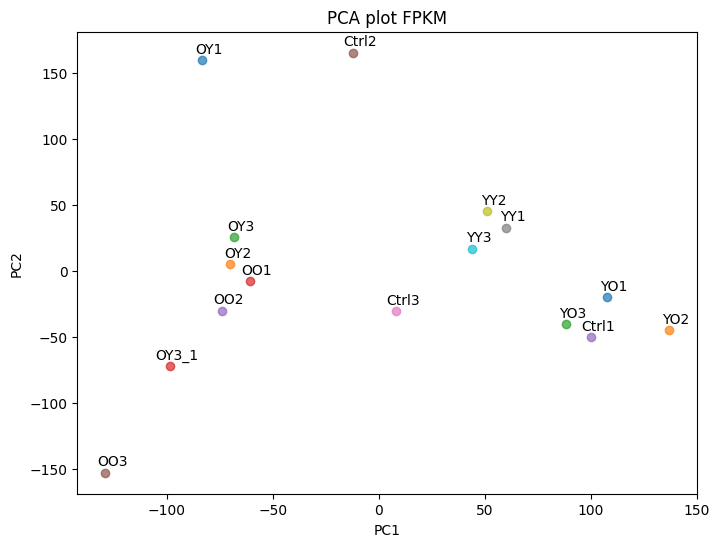

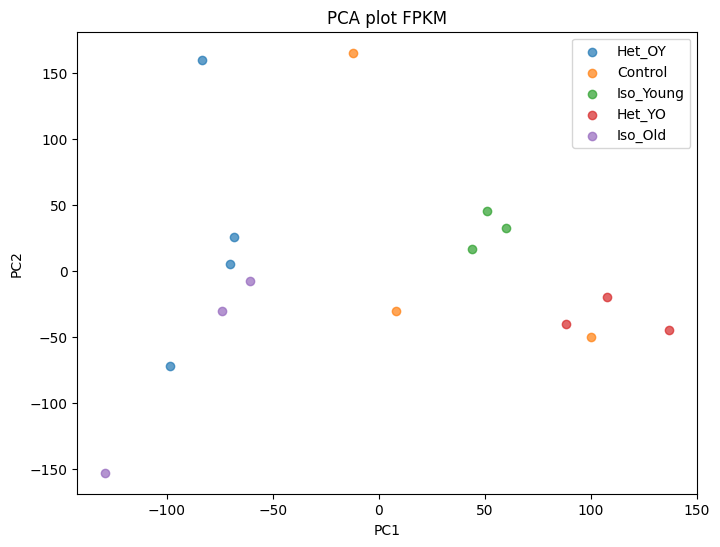

In [19]:
# Run run_PCA to assess sample variation before any normalization
PCA_save_dir = '/Volumes/Elements/20240213_Serum_Change_RNAseq_novogene/Results_Yuchen/0_PCA/'

run_PCA_fpkm(df=fpkm_df, standardize=True, n_components=4, 
        metadata = metadata_fpkm,
        plot_title='PCA plot FPKM',
        normalization_method='FPKM',
        save_dir = PCA_save_dir)

In [22]:
# Build a dataframe with sample-condition annotation (serving as metadata for DESeq2)
conditions_annotate = {'Ctrl1':'Control', 'Ctrl2':'Control', 'Ctrl3':'Control',
                       'YY1':'Iso_Young', 'YY2':'Iso_Young', 'YY3':'Iso_Young', 
                       'YO1':'Het_YO', 'YO2':'Het_YO', 'YO3':'Het_YO',
                       'OY1':'Het_OY', 'OY2':'Het_OY', 'OY3':'Het_OY', 
                       'OO1':'Iso_Old', 'OO2':'Iso_Old', 'OO3':'Iso_Old', 
                       'OY3_1':'Het_OY'
                       }

condition_metadata = pd.Series(conditions_annotate)
metadata = pd.DataFrame(condition_metadata)
metadata.columns = ['condition']
metadata

,condition
Ctrl1,Control
Ctrl2,Control
Ctrl3,Control
YY1,Iso_Young
YY2,Iso_Young
YY3,Iso_Young
YO1,Het_YO
YO2,Het_YO
YO3,Het_YO
OY1,Het_OY


In [23]:
Normalized_counts_save_dir = '/Volumes/Elements/20240213_Serum_Change_RNAseq_novogene/Results_Yuchen/1_Normalized_Counts/'

metadata.to_excel(Normalized_counts_save_dir + 'metadata.xlsx')